In [2]:
from pathlib import Path
from urllib.parse import urlparse
import requests
import json
from PIL import Image
from io import BytesIO
from matplotlib import patches
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
subscription_key = ""

ENDPOINT = ''

face_api_url = "" + '/face/v1.0/detect'

face_api_url_verify = "" + '/face/v1.0/verify'

In [ ]:
pip install azure.cognitiveservices.vision.face

In [12]:
def get_keypoints(image_url, subscription_key, face_api_url):

    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
        'returnFaceId': 'true',
        'returnFaceLandmarks': 'false',
        'returnFaceAttributes':
        'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }
        
    response = requests.post(face_api_url, params=params,
                         headers=headers, json={"url": image_url})

    keypoints = response.json()
    print(json.dumps(response.json(),indent=2))

In [13]:
image_url = 'https://i.insider.com/5cfeb50f25f2e710336b7857?width=700'
get_keypoints(image_url, subscription_key, face_api_url)

[
  {
    "faceId": "4e831ec0-7686-49e5-a5f5-8670d0bbf125",
    "faceRectangle": {
      "top": 152,
      "left": 287,
      "width": 220,
      "height": 220
    },
    "faceAttributes": {
      "smile": 0.01,
      "headPose": {
        "pitch": -14.1,
        "roll": 0.1,
        "yaw": 8.7
      },
      "gender": "female",
      "age": 25.0,
      "facialHair": {
        "moustache": 0.0,
        "beard": 0.0,
        "sideburns": 0.0
      },
      "glasses": "NoGlasses",
      "emotion": {
        "anger": 0.0,
        "contempt": 0.004,
        "disgust": 0.0,
        "fear": 0.0,
        "happiness": 0.01,
        "neutral": 0.986,
        "sadness": 0.0,
        "surprise": 0.0
      },
      "blur": {
        "blurLevel": "low",
        "value": 0.0
      },
      "exposure": {
        "exposureLevel": "goodExposure",
        "value": 0.52
      },
      "noise": {
        "noiseLevel": "low",
        "value": 0.16
      },
      "makeup": {
        "eyeMakeup": true,
     

In [15]:
def annotate_image(image_url, subscription_key, api_url, show_face_id=False):
    headers = {'Ocp-Apim-Subscription-Key': subscription_key}

    params = {
        'returnFaceId': 'true',
        'returnFaceLandmarks': 'false',
        'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
    }

    parsed_url = urlparse(image_url)
    if parsed_url.scheme == 'file':
        image_data = open(parsed_url.path, "rb").read()
        headers['Content-Type']='application/octet-stream'
        response = requests.post(api_url, params=params, headers=headers, data=image_data)
        image = Image.open(parsed_url.path)
    else:
        response = requests.post(api_url, params=params, headers=headers, json={"url": image_url})
        image_file = BytesIO(requests.get(image_url).content)
        image = Image.open(image_file)

    faces = response.json()

    fig, ax = plt.subplots(figsize=(10,10))

    ax.imshow(image, alpha=0.6)
    for face in faces:
        fr = face["faceRectangle"]
        fa = face["faceAttributes"]
        origin = (fr["left"], fr["top"])
        p = patches.Rectangle(origin, fr["width"],
                            fr["height"], fill=False, linewidth=2, color='b')
        ax.axes.add_patch(p)
        ax.text(origin[0], origin[1], "%s, %d"%(fa["gender"].capitalize(), fa["age"]),
                fontsize=16, weight="bold", va="bottom")

        if show_face_id:
            ax.text(origin[0], origin[1]+fr["height"], "%s"%(face["faceId"][:5]),
            fontsize=12, va="bottom")
    ax.axis("off")
    plt.close()
    return fig, faces

In [16]:
def face_compare(id_1, id_2, api_url):
    headers = {
        'Content-Type': 'application/json',
        'Ocp-Apim-Subscription-Key': subscription_key
    }

    body = {"faceId1": id_1, "faceId2": id_2}

    params = {}
    response = requests.post(api_url,
                            params=params,
                            headers=headers,
                            json=body)
    return response.json()

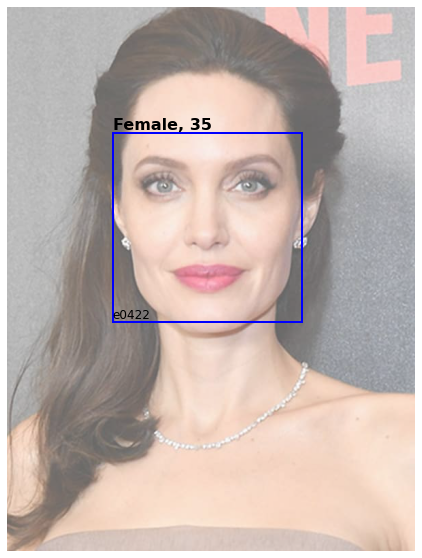

In [18]:
labeled_image, response_1 = annotate_image(
    'https://www.wzrost-waga.pl/wp-content/uploads/2019/10/angelina-jolie.jpg',
    subscription_key,
    face_api_url,
    show_face_id=True)

labeled_image

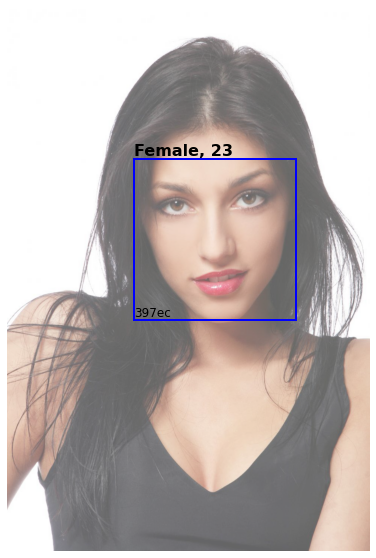

In [21]:
john_k_2 = 'https://freerangestock.com/sample/138649/young-woman-with-dark-hair-looking-at-camera.jpg'
labeled_image, response_2 = annotate_image(john_k_2,
                                           subscription_key,
                                           face_api_url,
                                           show_face_id=True)
labeled_image

In [22]:
face_compare(response_2[0]['faceId'], response_1[0]['faceId'], face_api_url_verify)

{'isIdentical': False, 'confidence': 0.07834}